----------------------------------IMAGE FORGERY DETECTION---------------------------------------------

Importing required libraries

In [1]:
import os
from PIL import Image,ImageChops,ImageEnhance
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf

Function to convert an image to ela image

In [2]:
def ela_image(path, quality=90):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png' 
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff 
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)  
    return ela_image

Checking whether images are opening properly or not

In [3]:
Real_image_path="C:/Users/matee/Image_Forgery_Detection/CASIA2/Au/Au_ani_00081.jpg"
Fake_image_path="C:/Users/matee/Image_Forgery_Detection/CASIA2/Tp/Tp_D_CRN_M_N_ani10101_ani00081_10139.tif"

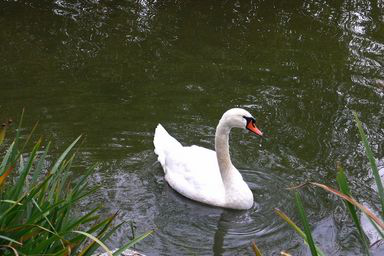

In [4]:
Image.open(Real_image_path)

ELA version of above image

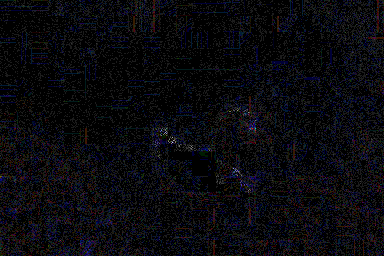

In [5]:
ela_image(Real_image_path)

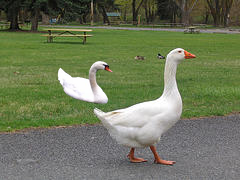

In [6]:
Image.open(Fake_image_path)

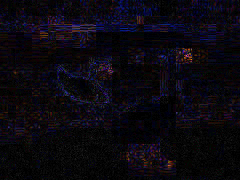

In [7]:
ela_image(Fake_image_path)

Preprocessing an image

In [8]:
image_size=(128,128)

The below preprocessing function converts the image to ELA image and resizes it and flattens it to a vector and then normalizes the pixel values

In [9]:
def preprocessing(image_path):
    return np.array(ela_image(image_path).resize(image_size)).flatten()/255

In [22]:
preprocessing(Real_image_path)

array([0.01176471, 0.0627451 , 0.0627451 , ..., 0.04313725, 0.03137255,
       0.07058824])

In [23]:
# ELA converted images
X = [] 
# 0 for fake, 1 for real
Y = [] 

In [24]:
import random
path = 'C:/Users/matee/Image_Forgery_Detection/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)  
        if len(Y) % 3000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 3000 == 0:
        break

print(len(X), len(Y))

Processing 3000 images
3000 3000


In [25]:
path = 'C:/Users/matee/Image_Forgery_Detection/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
        if len(Y) % 8000 == 0:
            print(f'Processing {len(Y)} images')
            break
    if len(Y) % 8000 == 0:
        break

print(len(X), len(Y))

Processing 8000 images
8000 8000


Shuffling the data

In [26]:
from sklearn.utils import shuffle
for i in range(10):
    X, Y = shuffle(X, Y, random_state=i)

Reshaping the data 

In [27]:
from keras.utils import to_categorical

In [28]:
X = np.array(X)
print("X shape = ",X.shape)
Y = to_categorical(Y, 2)
print("Y shape = ",Y.shape)
X = X.reshape(-1, 128, 128, 3)
print("X shape = ",X.shape)

X shape =  (8000, 49152)
Y shape =  (8000, 2)
X shape =  (8000, 128, 128, 3)


Splitting the data into training and testing or validation sets

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state=42)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

5600 5600
2400 2400


Configuring the Convolution Neural Network

In [30]:
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping

In [31]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model

Printing the summary of the model configuration

In [32]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 flatten (Flatten)           (None, 26912)             0

Compiling the model by assigning appropriate loss function, optimizer and metrics

In [33]:
from keras import losses 
from keras import optimizers 
from keras import metrics

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

Training the model

In [35]:
batch_size = 32 
epochs = 10

In [36]:
#Reference - https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
# To find optimal number of epochs to train a model using "Early Stopping Technique" 
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=3,
                                        restore_best_weights=True)

In [37]:
history = model.fit(
    X_train, Y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[earlystopping]
    )

Epoch 1/10
175/175 [==============================] - 51s 271ms/step - loss: 0.6585 - accuracy: 0.6327 - val_loss: 0.6015 - val_accuracy: 0.7321
Epoch 2/10
175/175 [==============================] - 38s 216ms/step - loss: 0.5596 - accuracy: 0.7480 - val_loss: 0.5258 - val_accuracy: 0.7696
Epoch 3/10
175/175 [==============================] - 35s 199ms/step - loss: 0.5118 - accuracy: 0.7659 - val_loss: 0.4893 - val_accuracy: 0.7792
Epoch 4/10
175/175 [==============================] - 38s 217ms/step - loss: 0.4838 - accuracy: 0.7804 - val_loss: 0.5611 - val_accuracy: 0.7833
Epoch 5/10
175/175 [==============================] - 32s 183ms/step - loss: 0.4694 - accuracy: 0.8061 - val_loss: 0.4474 - val_accuracy: 0.8183
Epoch 6/10
175/175 [==============================] - 38s 219ms/step - loss: 0.4477 - accuracy: 0.8239 - val_loss: 0.4700 - val_accuracy: 0.8238
Epoch 7/10
175/175 [==============================] - 37s 209ms/step - loss: 0.4307 - accuracy: 0.8407 - val_loss: 0.4116 - val_ac

In [38]:
loss,accuracy=model.evaluate(X_val, Y_val)

75/75 [==============================] - 4s 48ms/step - loss: 0.3925 - accuracy: 0.8550


In [39]:
print("loss= ",loss)
print("accuracy= ",accuracy)

loss=  0.39248737692832947
accuracy=  0.8550000190734863


Saving the model

In [40]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb#scrollTo=5NDMO_7kS6Do
model.save('model_a85.h5') 

Reloadoing the model

In [10]:
from tensorflow.keras.models import load_model
# Recreate the exact same model, including its weights and the optimizer
new_model = load_model("model_a85.h5")

Checking whether the loaded model has same accuracy as saved model

In [42]:
loss,accuracy=new_model.evaluate(X_val, Y_val)

75/75 [==============================] - 4s 45ms/step - loss: 0.3925 - accuracy: 0.8550


Defining the output class names

In [11]:
class_names = ['fake', 'real']

Predicting the output for a sample image along with confidence percentage

In [12]:
image_predict = "C:/Users/matee/Image_Forgery_Detection/CASIA2/Tp/Tp_D_CRN_M_N_ani10101_ani00081_10139.tif"
image = preprocessing(image_predict)
image = image.reshape(-1, 128, 128, 3)
y_pred = new_model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class is: {class_names[y_pred_class]} \nConfidence percent: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 384ms/step
Class is: fake 
Confidence percent: 98.97


Epoch v/s Accuracy of training and testing sets

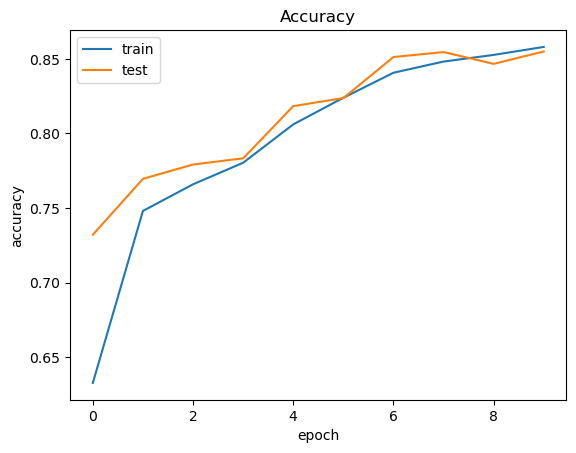

In [47]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

Epoch v/s Loss of training and testing sets

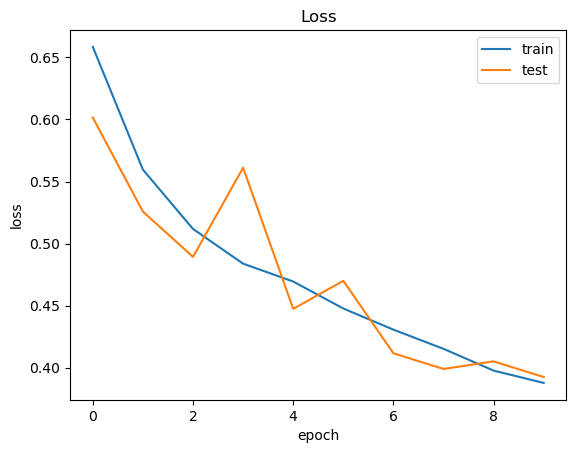

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

Plotting the confusion matrix

In [49]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

75/75 [==============================] - 4s 49ms/step


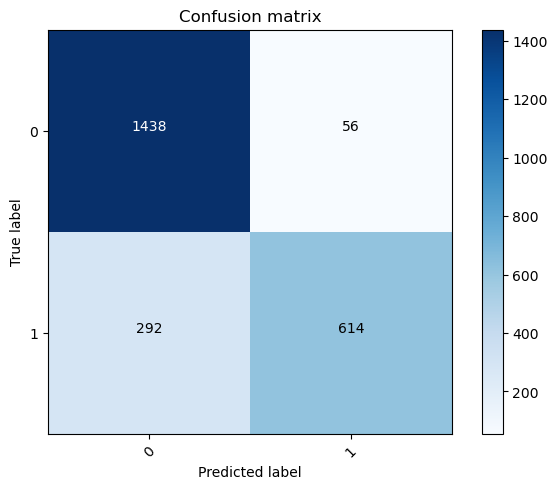

In [50]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

Backend using flask

In [53]:
!pip install flask
!pip install pyngrok==4.1.1
!pip install flask_ngrok

In [13]:
from flask import Flask, flash, request, redirect, url_for, render_template
from werkzeug.utils import secure_filename
from flask_ngrok import run_with_ngrok

In [14]:
from flask import Flask, flash, request, redirect, url_for, render_template
import urllib.request
import os
from werkzeug.utils import secure_filename
 
!ngrok authtoken 2HFX6zbW3w5q5cZv6703lG5u1HL_3fVS7PL6xxme3ECU4L2qa
app = Flask(__name__,template_folder="static/templates/")
UPLOAD_FOLDER = 'static/uploads'
app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024
run_with_ngrok(app)

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif','tif'])
 
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS
     
 
@app.route('/')
def home():
    return render_template('home.html')
 
@app.route('/', methods=['POST','GET'])
def upload_image():
    if 'file' not in request.files:
        flash('No file part')
        return redirect(request.url)
    file = request.files['file']
    if file.filename == '':
        flash('No image selected for uploading')
        return redirect(request.url)
    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
        #print('upload_image filename: ' + filename)
        flash('Image uploaded successfully')
        full_path = os.path.join("static/uploads/", filename)
        ela_image1 = ela_image(full_path)
        ela_path = os.path.join("static/ela",filename)
        ela_image1.save(ela_path)
        image = preprocessing(full_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = new_model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        print(class_names[y_pred_class])
        return render_template('home.html', filename=filename,result=class_names[y_pred_class],image=full_path,ela_image = ela_path)
    else:
        flash('Allowed image types are - png, jpg, jpeg, gif,tif')
        return redirect(request.url)
 

app.run()

Authtoken saved to configuration file: C:\Users\matee/.ngrok2/ngrok.yml
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [17/May/2023 12:03:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 12:03:07] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 50ms/step


127.0.0.1 - - [17/May/2023 12:03:15] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 12:03:16] "GET /static/uploads/Tp_D_NNN_S_N_ani00010_ani00017_10215.jpg HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 12:03:16] "GET /static/ela/Tp_D_NNN_S_N_ani00010_ani00017_10215.jpg HTTP/1.1" 200 -


fake


127.0.0.1 - - [17/May/2023 12:03:51] "GET /static/ela/Tp_D_NNN_S_N_ani00010_ani00017_10215.jpg HTTP/1.1" 200 -
127.0.0.1 - - [17/May/2023 12:04:38] "GET /static/uploads/Tp_D_NNN_S_N_ani00010_ani00017_10215.jpg HTTP/1.1" 200 -
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\matee\anaconda3\envs\myprojectenv\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "C:\Users\matee\anaconda3\envs\myprojectenv\lib\threading.py", line 1378, in run
    self.function(*self.args, **self.kwargs)
  File "C:\Users\matee\anaconda3\envs\myprojectenv\lib\site-packages\flask_ngrok.py", line 70, in start_ngrok
    ngrok_address = _run_ngrok()
  File "C:\Users\matee\anaconda3\envs\myprojectenv\lib\site-packages\flask_ngrok.py", line 18, in _run_ngrok
    _download_ngrok(ngrok_path)
  File "C:\Users\matee\anaconda3\envs\myprojectenv\lib\site-packages\flask_ngrok.py", line 56, in _download_ngrok
    with zipfile.ZipFile(download_path, "r") as zip_ref:
  Fil

-----------------------------------Existing System----------------------------------------------------

In [53]:
def existing_preprocessing(image_path):
    image = Image.open(image_path).convert('RGB')
    return np.array(image.resize(image_size)).flatten()/255

In [54]:
preprocessed_image = existing_preprocessing(Real_image_path)

In [55]:
print(preprocessed_image)

[0.12156863 0.1254902  0.07058824 ... 0.55686275 0.54901961 0.69019608]


In [57]:
# ELA converted images
XE = [] 
# 0 for fake, 1 for real
YE = []

In [58]:
import random
path = 'C:/Users/matee/Image_Forgery_Detection/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            XE.append(existing_preprocessing(full_path))
            YE.append(1)  
        if len(YE) % 3000 == 0:
            print(f'Processing {len(YE)} images')
            break
    if len(YE) % 3000 == 0:
        break

print(len(XE), len(YE))

Processing 3000 images
3000 3000


In [59]:
path = 'C:/Users/matee/Image_Forgery_Detection/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
            full_path = os.path.join(dirname, filename)
            XE.append(existing_preprocessing(full_path))
            YE.append(0)
        if len(YE) % 8000 == 0:
            print(f'Processing {len(YE)} images')
            break
    if len(YE) % 8000 == 0:
        break

print(len(XE), len(YE))

Processing 8000 images
8000 8000


In [60]:
from sklearn.utils import shuffle
for i in range(10):
    XE, YE = shuffle(XE, YE, random_state=i)

In [61]:
from keras.utils import to_categorical

In [62]:
XE = np.array(XE)
print("XE shape = ",XE.shape)
YE = to_categorical(YE, 2)
print("YE shape = ",YE.shape)
XE = XE.reshape(-1, 128, 128, 3)
print("XE shape = ",XE.shape)

XE shape =  (8000, 49152)
YE shape =  (8000, 2)
XE shape =  (8000, 128, 128, 3)


In [63]:
from sklearn.model_selection import train_test_split
XE_train, XE_val, YE_train, YE_val = train_test_split(XE, YE, test_size = 0.3, random_state=42)
print(len(XE_train), len(YE_train))
print(len(XE_val), len(YE_val))

5600 5600
2400 2400


In [64]:
existing_model=build_model()
existing_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 32)        12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 29, 29, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 26912)            

In [65]:
existing_model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

In [66]:
existing_model_history = existing_model.fit(
    XE_train, YE_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(XE_val, YE_val),
    callbacks=[earlystopping]
    )

Epoch 1/10
175/175 [==============================] - 46s 235ms/step - loss: 0.6560 - accuracy: 0.6246 - val_loss: 0.6501 - val_accuracy: 0.6225
Epoch 2/10
175/175 [==============================] - 39s 220ms/step - loss: 0.6472 - accuracy: 0.6293 - val_loss: 0.6448 - val_accuracy: 0.6288
Epoch 3/10
175/175 [==============================] - 39s 223ms/step - loss: 0.6422 - accuracy: 0.6366 - val_loss: 0.6418 - val_accuracy: 0.6329
Epoch 4/10
175/175 [==============================] - 37s 211ms/step - loss: 0.6398 - accuracy: 0.6445 - val_loss: 0.6384 - val_accuracy: 0.6433
Epoch 5/10
175/175 [==============================] - 36s 207ms/step - loss: 0.6351 - accuracy: 0.6496 - val_loss: 0.6355 - val_accuracy: 0.6429
Epoch 6/10
175/175 [==============================] - 39s 221ms/step - loss: 0.6320 - accuracy: 0.6587 - val_loss: 0.6341 - val_accuracy: 0.6454
Epoch 7/10
175/175 [==============================] - 36s 208ms/step - loss: 0.6294 - accuracy: 0.6604 - val_loss: 0.6321 - val_ac

In [72]:
existing_model.save('existing_model_a66.h5')

Epoch v/s Accuracy of testing data for Existing and Proposed systems

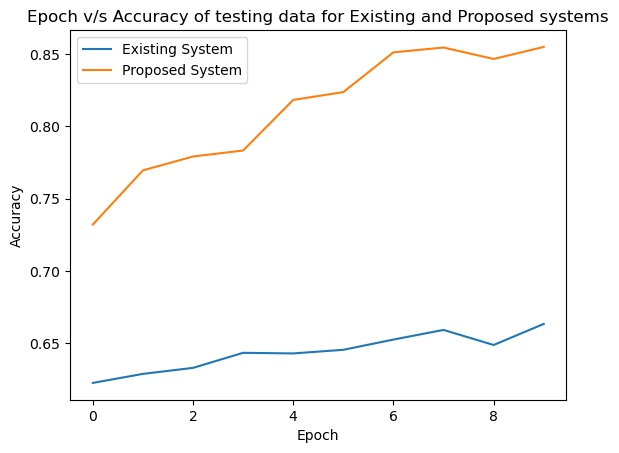

In [69]:
import matplotlib.pyplot as plt
plt.plot(existing_model_history.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Epoch v/s Accuracy of testing data for Existing and Proposed systems")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Existing System','Proposed System'])
plt.show()